In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import marshal
import pickle
import datetime as dt
from scipy.interpolate import interp1d

# %matplotlib notebook 
%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15, 6


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
import os
elm_keys = dict()
path ='../datastore/paystations/'
for i in os.listdir(path):
    if i.endswith(".d") or i.endswith(".py"): 
        key = i.split('_')[0]
        elm_keys[key] = pickle.load(open(path + i, 'rb'))
        print 'paystation %s loaded' % key

paystation 17066 loaded
paystation 32489 loaded
paystation 8005 loaded


In [95]:
import matplotlib.cm as cm
clr = np.linspace(0, 1, len(elm_keys.keys()))

def plot_paystation(data, key, i):
    y = data.flatten()
    x = np.linspace(1, len(y), num=len(y))
    plt.plot(x, y, color=cm.cool(clr[i]))
    plt.ylabel('Parked cars')
    plt.xlabel('Hour')
    plt.title('Density for paystation %s' % key)
    plt.show()
    



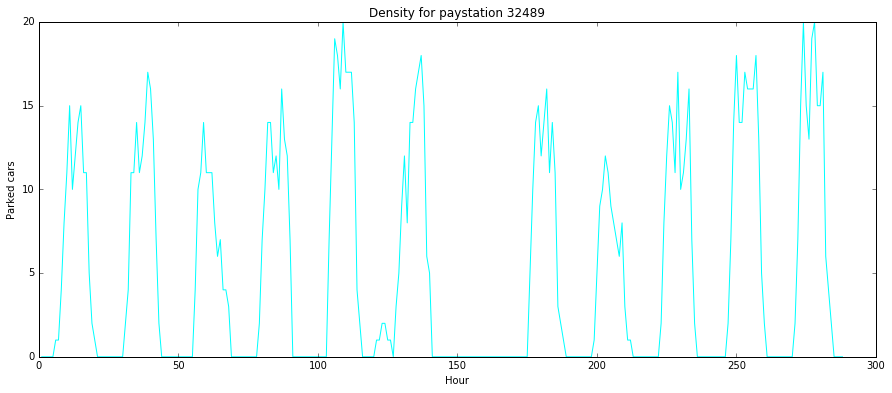

Paystation 32489 popularity = 39405


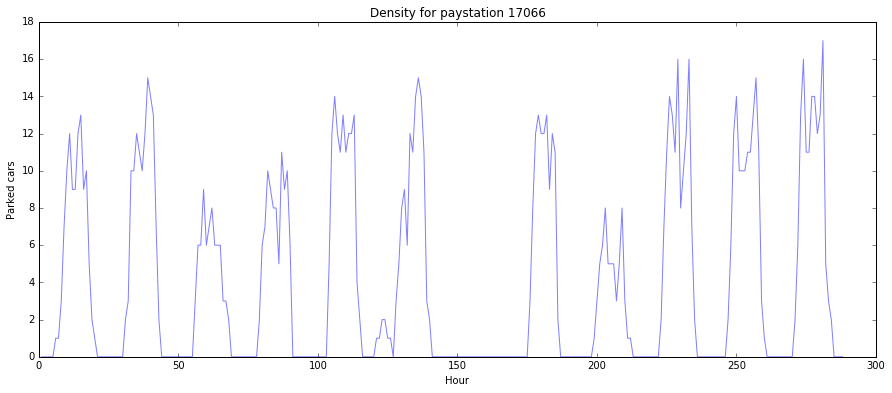

Paystation 17066 popularity = 27985


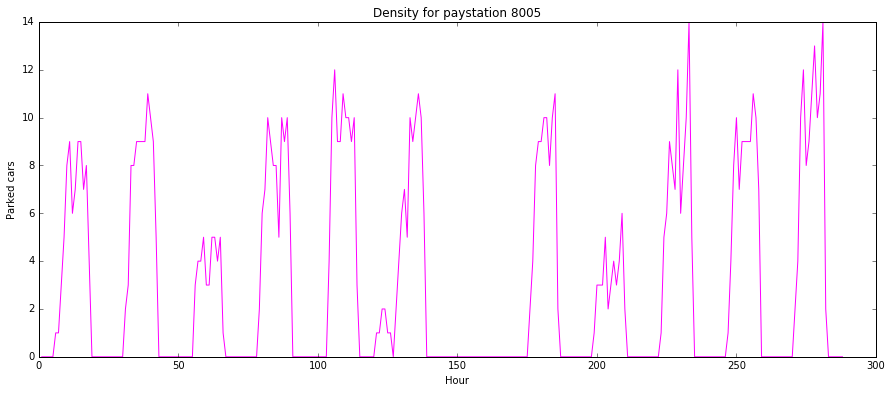

Paystation 8005 popularity = 20483


In [97]:
for i, key in enumerate(elm_keys.keys()):
    data = elm_keys[key]
    data = data[0:12]
    plot_paystation(data, key, i)
    print 'Paystation %s popularity = %d' % (key, np.sum(elm_keys[key]))



In [ ]:

# # p.append(pickle.load(open('../datastore/paystations/8005_3_days.d', 'rb')))
# # p.append(pickle.load(open('../datastore/paystations/17066_3_days.d', 'rb')))
# # p.append(pickle.load(open('../datastore/paystations/32489_3_days.d', 'rb')))
# # p.append(pickle.load(open('../datastore/paystations/35502_3_days.d', 'rb')))
# # p.append(pickle.load(open('../datastore/paystations/76429_3_days.d', 'rb')))
# p.append(pickle.load(open('../datastore/paystations/8005_374_days.d', 'rb')))
# p.append(pickle.load(open('../datastore/paystations/17066_374_days.d', 'rb')))
# p.append(pickle.load(open('../datastore/paystations/32489_374_days.d', 'rb')))

#     f = interp1d(x, y, kind='cubic')
#     x_interp = np.linspace(1, len(y), num=len(y)*10)
#     plt.plot(y, 'o', x_interp, f(x_interp), '-')